# Waywo Project Visualization (UMAP + HDBSCAN)

This notebook loads project embeddings from the SQLite database, reduces them to 2D with UMAP, and clusters them with HDBSCAN.

## Setup

Imports and database path detection.

In [1]:
import sys
sys.path.insert(0, '/app')

# Enable async support in Jupyter
import nest_asyncio
nest_asyncio.apply()

In [2]:
from pathlib import Path
import json

import numpy as np
import pandas as pd
import umap
import hdbscan
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

/app/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/app/.venv/lib/python3.12/site-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


In [3]:
# Locate the SQLite DB regardless of whether the notebook is run from repo root or notebooks/
cwd = Path.cwd().resolve()
db_path = (cwd / 'data' / 'waywo.db') if (cwd / 'data' / 'waywo.db').exists() else (cwd.parent / 'data' / 'waywo.db')
db_path

PosixPath('/app/data/waywo.db')

In [4]:
import sqlite3

query = '''
SELECT
  id,
  title,
  short_description,
  description,
  hashtags,
  idea_score,
  complexity_score,
  description_embedding
FROM waywo_projects
WHERE is_valid_project = 1
  AND description_embedding IS NOT NULL
'''

with sqlite3.connect(db_path) as conn:
    df = pd.read_sql_query(query, conn)

df.head()

,id,title,short_description,description,hashtags,idea_score,complexity_score,description_embedding
0,1,Terraform Provider Network Mirror,Terraform provider mirror aiming for generic a...,It is a Terraform provider that mirrors networ...,"[""terraform"", ""proxy"", ""cache"", ""devops""]",7,8,b'\x00\x00\xc6<\x00\x00\xe4<\x00\x00\x00<\x00\...
1,2,CAP Inversion for Distributed Scaling,Exploring CAP theorem inversion for massive sc...,It is a research prototype aiming to split the...,"[""distributed"", ""scaling"", ""cap"", ""research""]",6,9,b'\x00\x00p<\x00\x00@;\x00\x00\x11<\x00\x00!\x...
2,3,Lumi AI: Automated Product Content Generation,AI-powered Shopify app generating SEO content,Lumi AI is a Shopify app that automates produc...,"[""ai"", ""shopify"", ""ecommerce"", ""seo"", ""vision""]",8,7,b'\x00\x00\xae\xbb\x00\x00\xf1\xbc\x00\x00\x9c...
3,5,echu,"Converts long reads, books, videos into readab...","echu is a tiny app that transforms long reads,...","[""productivity"", ""reading"", ""youtube"", ""books""...",6,3,"b""\x00\x00\xa9\xbb\x00\x00\x8e<\x00\x00\xc8<\x..."
4,6,Trivyn Knowledge Platform,Single executable ontology-driven knowledge base,Trivyn is a single executable ontology-first k...,"[""knowledge"", ""ontology"", ""rust"", ""privacy"", ""...",6,7,b'\x00\x00B\xb9\x00\x00\xad;\x00\x004<\x00\x00...


In [5]:
# Decode embeddings from SQLite BLOBs (little-endian float32)
def blob_to_vec(blob: bytes) -> np.ndarray:
    return np.frombuffer(blob, dtype='<f4')

embeddings = [blob_to_vec(b) for b in df['description_embedding']]
lengths = pd.Series([len(v) for v in embeddings])

# Keep only the most common vector length (defensive against any malformed rows)
target_len = int(lengths.mode().iloc[0])
mask = lengths == target_len
df = df.loc[mask].reset_index(drop=True)
embeddings = [v for v, keep in zip(embeddings, mask) if keep]

X = np.vstack(embeddings)
X.shape

(443, 4096)

In [6]:
# UMAP reduction to 2D
X_scaled = StandardScaler(with_mean=True, with_std=True).fit_transform(X)

reducer = umap.UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.1,
    metric='cosine',
    random_state=42,
)

umap_2d = reducer.fit_transform(X_scaled)
df['x'] = umap_2d[:, 0]
df['y'] = umap_2d[:, 1]
df[['x', 'y']].head()

/app/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


,x,y
0,2.610050,7.496395
1,3.324550,7.466466
2,6.478703,8.985121
3,5.361073,6.387256
4,6.004129,8.688718


In [7]:
# HDBSCAN clustering on the 2D projection
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=10,
    min_samples=5,
    metric='euclidean',
    cluster_selection_method='eom',
)

labels = clusterer.fit_predict(umap_2d)
df['cluster'] = labels

df['cluster'].value_counts().sort_index()

cluster
-1     132
 0      21
 1      21
 2      11
 3      12
 4      14
 5      12
 6      20
 7      18
 8      15
 9     123
 10     11
 11     33
Name: count, dtype: int64

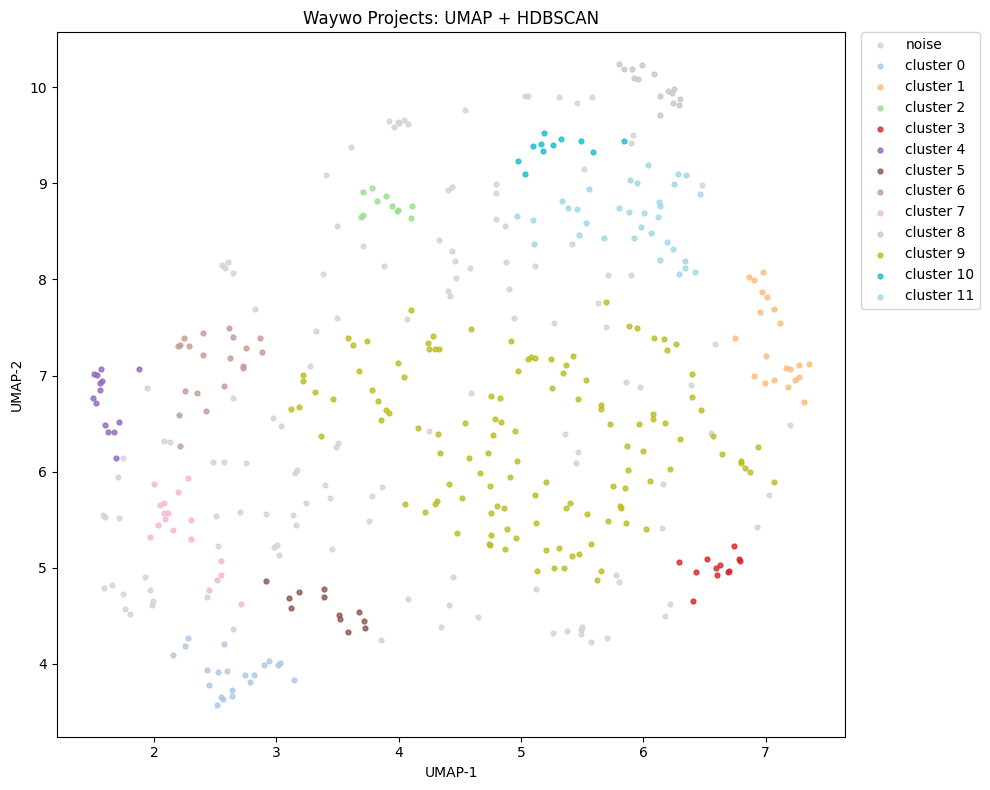

In [8]:
# 2D scatter plot colored by cluster
plt.figure(figsize=(10, 8))

clusters = sorted(df['cluster'].unique())
colors = plt.cm.tab20(np.linspace(0, 1, max(len(clusters), 1)))

for i, cluster_id in enumerate(clusters):
    cluster_mask = df['cluster'] == cluster_id
    color = 'lightgray' if cluster_id == -1 else colors[i % len(colors)]
    label = 'noise' if cluster_id == -1 else f'cluster {cluster_id}'
    plt.scatter(
        df.loc[cluster_mask, 'x'],
        df.loc[cluster_mask, 'y'],
        s=12,
        alpha=0.8,
        c=[color],
        label=label,
    )

plt.title('Waywo Projects: UMAP + HDBSCAN')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.show()

In [9]:
# Peek at a few titles per cluster (excluding noise)
sampled = (
    df[df['cluster'] != -1]
    .groupby('cluster', as_index=False)
    .head(5)
    .sort_values('cluster')
    [['cluster', 'title', 'short_description']]
)
sampled

,cluster,title,short_description
53,0,Jetson Orin Nano Field Kit,Pre-built kit for Jetson Orin Nano with camera...
42,0,Framebench CAN Bus Utilities,Utilities for parsing and building CAN bus frames
98,0,Mosaichord Electronic Music Controller,Seven-limit just intonation electronic music c...
111,0,Voron 2.4 Belt Tension Meter,Load cell tension meter for Voron 2.4 printers
99,0,The Ticker Screen,Huge LED sports ticker display
67,1,Reinforced Learning Platform,AI-powered spaced repetition flashcards for ma...
64,1,Reading Skill Tracker,K-12 reading practice with speech assessment a...
85,1,Divepod Adaptive Learning Program,Adaptive computer science education for teens ...
86,1,TryBackprop ML Learning Blog,Blog teaching ML concepts and interview prep
44,1,AI Study Buddy,Peer-level AI study companion for high school ...
